### Imports

In [32]:
import numpy as np
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from xgboost import plot_importance

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression

from torch import nn
import neural_network
import losses
import torch

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [33]:
# df = pd.read_csv("../data/clean2_data_normalized.csv", index_col=0)
df = pd.read_csv("cleaned_data_ext_norm.csv", index_col=0)

In [34]:
seed = 100
test_size = 0.15
X = df.drop(columns=["TARGET", "SK_ID_CURR"], axis=1)
y = df["TARGET"]

k = 5
kf = KFold(n_splits=k, random_state=None)


# note: stratify=df.buy generates
# X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=test_size, random_state=seed, stratify=y)
# classes_weights = class_weight.compute_sample_weight(
#     class_weight='balanced',
#     y=y_train
# )

In [35]:
logreg = LogisticRegression(class_weight='balanced', max_iter=10000)

best_log_model = None
max_log_f1 = 0
log_Xtr, log_Xte, log_ytr, log_yte = None, None, None, None


for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
     
    logreg.fit(X_train,y_train)
    pred_values = logreg.predict(X_test)
     
    f1_te = f1_score(y_test, pred_values)
    if f1_te > max_log_f1:
        max_log_f1 = f1_te
        best_log_model = logreg
        log_Xtr, log_Xte, log_ytr, log_yte = X_train, X_test, y_train, y_test

print("Best F1: ", max_log_f1)

Best F1:  0.2574704342330956


In [36]:
tn, fp, fn, tp = confusion_matrix(log_yte, best_log_model.predict(log_Xte)).ravel()
tn, fp, fn, tp

(33708, 15061, 1337, 2873)

In [37]:
best_tree_model = None
max_tree_f1 = 0
tree_Xtr, tree_Xte, tree_ytr, tree_yte = None, None, None, None

for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]

    classes_weights = class_weight.compute_sample_weight(
        class_weight='balanced',
        y=y_train
    )

    xgb_model = XGBClassifier(base_score=np.sum(y_train == 0)/len(y_train), max_depth=10)
    xgb_model.fit(X_train, y_train, sample_weight=classes_weights)
     
    pred_values = xgb_model.predict(X_test)
     
    f1_te = f1_score(y_test, pred_values)
    if f1_te > max_tree_f1:
        max_tree_f1 = f1_te
        best_tree_model = xgb_model
        tree_Xtr, tree_Xte, tree_ytr, tree_yte = X_train, X_test, y_train, y_test

print("Best F1: ", max_tree_f1)

Best F1:  0.2655255983035444


In [38]:
tn, fp, fn, tp = confusion_matrix(tree_yte, best_log_model.predict(tree_Xte)).ravel()
tn, fp, fn, tp

(33708, 15061, 1337, 2873)

In [39]:
feat_dict= {}
for col, val in sorted(zip(X_train.columns, best_tree_model.feature_importances_),key=lambda x:x[1],reverse=True):
  feat_dict[col]=val
feat_df = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()})
feat_df[:10]

,Feature,Importance
0,EXT_SOURCE_3,0.024208
1,Higher education,0.022153
2,EXT_SOURCE_2,0.017239
3,car_owned_less_10,0.013945
4,CODE_GENDER,0.013902
5,EXT_SOURCE_1,0.011999
6,NAME_CONTRACT_TYPE,0.011827
7,Secondary / secondary special,0.011514
8,Transport: type 3,0.011244
9,REGION_RATING_CLIENT_W_CITY,0.011069


Text(0.5, 0, 'Importance')

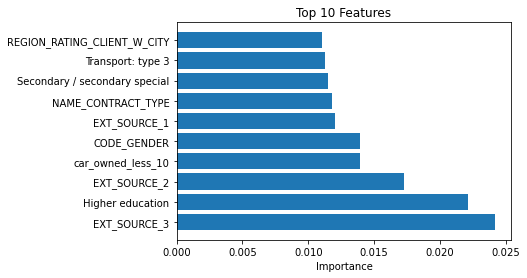

In [40]:
plt.barh(feat_df[:10]['Feature'], feat_df[:10]['Importance'])
plt.title("Top 10 Features")
plt.xlabel("Importance")

In [41]:
#Our rating of the region where client lives with taking city into account (1,2,3)
#organization type	


In [42]:
best_nn_model = None
max_nn_f1 = 0
nn_Xtr, nn_Xte, nn_ytr, nn_yte = None, None, None, None

output_dim = 1
num_epochs = 1000

for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]


    n, d = X_train.shape
    input_dim = d
    hidden_dim = d//2
    model_nn = neural_network.Model(input_dim, hidden_dim, output_dim)

    classes_weights = class_weight.compute_sample_weight(
        class_weight='balanced',
        y=y_train
    )

    
    model_nn = neural_network.train_regression_model(torch.tensor(X_train.values, dtype=torch.float32), 
                                        torch.tensor(y_train.values, dtype=torch.float32), 
                                        model_nn, 
                                        num_epochs, 
                                        loss_fn = losses.DiceBCELoss(weight=torch.tensor(classes_weights)),
                                        lr=1e-3, print_freq=25, display_loss=False)

    model_nn.eval()

    y_pred_te = model_nn(torch.tensor(X_test.values, dtype=torch.float32)).detach().numpy().flatten()
    y_pred_te = np.round(y_pred_te)
     
    f1_te = f1_score(y_test, y_pred_te)
    if f1_te > max_nn_f1:
        max_nn_f1 = f1_te
        best_nn_model = model_nn
        nn_Xtr, nn_Xte, nn_ytr, nn_yte = X_train, X_test, y_train, y_test

print("Best F1: ", max_nn_f1)

Best F1:  0.26200267551900114


In [43]:
tn, fp, fn, tp = confusion_matrix(nn_yte, best_log_model.predict(nn_Xte)).ravel()
tn, fp, fn, tp

(34128, 14777, 1298, 2776)

### Linear Regression --> Might want to switch this to soft SVM classifier bec this is not a regression task

In [4]:
# # linear model 
# x = sm.add_constant(X_train, prepend=False)
# lin_mod = sm.OLS(y_train, x.astype(float))
# lin_mod = lin_mod.fit()
# # print(lin_mod.summary())

In [5]:
# y_pred_tr = lin_mod.predict(x.astype(float))
# y_pred_te = lin_mod.predict(sm.add_constant(X_test, prepend=False).astype(float))

# accuracy_tr = accuracy_score(y_train, y_pred_tr)
# print("Train Accuracy: %.2f%%" % (accuracy_tr * 100.0))

# accuracy_te = accuracy_score(y_test, y_pred_te)
# print("Test Accuracy: %.2f%%" % (accuracy_te * 100.0))

# print('f1 score on train set', f1_score(y_train, y_pred_tr))
# print('f1 score on test set', f1_score(y_test, y_pred_te))

### Logistic Regression

In [6]:
logreg = LogisticRegression(class_weight='balanced', max_iter=100000)
logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=100000)

In [7]:
f1_tr = f1_score(y_train, logreg.predict(X_train))
print('f1 score on train set', f1_tr)

f1_te = f1_score(y_test, logreg.predict(X_test))
print('f1 score on test set', f1_te)

f1 score on train set 0.25595109517432063
f1 score on test set 0.25490674143606


In [8]:
print('Classification Report for Train Set: \n', classification_report(y_train, logreg.predict(X_train)))
print('Classification Report for Test Set: \n', classification_report(y_test, logreg.predict(X_test)))

Classification Report for Train Set: 
               precision    recall  f1-score   support

           0       0.96      0.70      0.81    207743
           1       0.16      0.68      0.26     17416

    accuracy                           0.69    225159
   macro avg       0.56      0.69      0.53    225159
weighted avg       0.90      0.69      0.76    225159

Classification Report for Test Set: 
               precision    recall  f1-score   support

           0       0.96      0.69      0.81     36661
           1       0.16      0.68      0.25      3074

    accuracy                           0.69     39735
   macro avg       0.56      0.69      0.53     39735
weighted avg       0.90      0.69      0.76     39735



In [9]:
tn, fp, fn, tp = confusion_matrix(y_train, logreg.predict(X_train)).ravel()
tn, fp, fn, tp

(144420, 63323, 5567, 11849)

In [10]:
print(roc_auc_score(y_train, logreg.predict(X_train)))
print(roc_auc_score(y_test, logreg.predict(X_test)))

0.6877686398582332
0.6868005480660107


### Extreme Gradient Boosted Trees


https://xgboost.readthedocs.io/en/stable/parameter.html

In [31]:
xgb_model = XGBClassifier(base_score=np.sum(y_train == 0)/len(y_train), max_depth=5, n_estimators = 1000, subsample=0.8, reg_lambda = 1)
xgb_model.fit(X_train, y_train, sample_weight=classes_weights)

XGBClassifier(base_score=0.9226502160695331, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [32]:
y_pred_tr = xgb_model.predict(X_train)
y_pred_te = xgb_model.predict(X_test)

accuracy_tr = accuracy_score(y_train, y_pred_tr)
print("Train Accuracy: %.2f%%" % (accuracy_tr * 100.0))

accuracy_te = accuracy_score(y_test, y_pred_te)
print("Test Accuracy: %.2f%%" % (accuracy_te * 100.0))

print('f1 score on train set', f1_score(y_train, y_pred_tr))
print('f1 score on test set', f1_score(y_test, y_pred_te))

Train Accuracy: 89.97%
Test Accuracy: 81.91%
f1 score on train set 0.6013870017116942
f1 score on test set 0.2595797280593325


In [33]:
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_tr).ravel()
tn, fp, fn, tp

(185530, 22213, 376, 17040)

In [34]:
print(roc_auc_score(y_train, y_pred_tr))
print(roc_auc_score(y_test, y_pred_te))

0.9357426365499024
0.6316515521583153


In [35]:
feat_dict= {}
for col, val in sorted(zip(X_train.columns, xgb_model.feature_importances_),key=lambda x:x[1],reverse=True):
  feat_dict[col]=val
feat_df = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()})
feat_df

,Feature,Importance
0,EXT_SOURCE_3,0.022298
1,CODE_GENDER,0.016468
2,EXT_SOURCE_2,0.014159
3,car_owned_less_10,0.014138
4,Higher education,0.013631
...,...,...
147,FLAG_EMP_PHONE,0.000000
148,Businessman,0.000000
149,Student,0.000000
150,Unemployed,0.000000


### Neural Network

In [16]:
n, d = X_train.shape
input_dim = d
hidden_dim = d//2
output_dim = 1
num_epochs = 1000
model_nn = neural_network.Model(input_dim, hidden_dim, output_dim)

classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',# {0: len(y_train)/np.sum(y_train == 0), 1: 1.5 * len(y_train)/np.sum(y_train == 1)},
    y=y_train
)

model_nn = neural_network.train_regression_model(torch.tensor(X_train.values, dtype=torch.float32), 
                                      torch.tensor(y_train.values, dtype=torch.float32), 
                                      model_nn, 
                                      num_epochs, 
                                      loss_fn = losses.DiceBCELoss(weight=torch.tensor(classes_weights)),
                                      # loss_fn = losses.DiceLoss(),
                                      # loss_fn = nn.BCELoss(weight=torch.tensor(classes_weights)), 
                                      lr=1e-3, print_freq=25, display_loss=True)

epoch 25 loss 1.5085399150848389
epoch 50 loss 1.474826455116272
epoch 75 loss 1.450129508972168
epoch 100 loss 1.4304406642913818
epoch 125 loss 1.4173903465270996
epoch 150 loss 1.4090189933776855
epoch 175 loss 1.404041051864624
epoch 200 loss 1.4012277126312256
epoch 225 loss 1.399289608001709
epoch 250 loss 1.3975447416305542
epoch 275 loss 1.395843744277954
epoch 300 loss 1.3940802812576294
epoch 325 loss 1.3922231197357178
epoch 350 loss 1.390364646911621
epoch 375 loss 1.3883862495422363
epoch 400 loss 1.386263132095337
epoch 425 loss 1.384049892425537
epoch 450 loss 1.38181734085083
epoch 475 loss 1.3796660900115967
epoch 500 loss 1.3776581287384033
epoch 525 loss 1.3756279945373535
epoch 550 loss 1.3737499713897705
epoch 575 loss 1.3718314170837402
epoch 600 loss 1.3700330257415771
epoch 625 loss 1.3682763576507568
epoch 650 loss 1.3666285276412964
epoch 675 loss 1.36503267288208
epoch 700 loss 1.3635023832321167
epoch 725 loss 1.362007737159729
epoch 750 loss 1.3606145381927

In [17]:
model_nn.eval()

y_pred_tr = model_nn(torch.tensor(X_train.values, dtype=torch.float32)).detach().numpy().flatten()
y_pred_tr = np.round(y_pred_tr)
y_pred_te = model_nn(torch.tensor(X_test.values, dtype=torch.float32)).detach().numpy().flatten()
y_pred_te = np.round(y_pred_te)

accuracy_tr = accuracy_score(y_train, y_pred_tr)
print("Train Accuracy: %.2f%%" % (accuracy_tr * 100.0))

accuracy_te = accuracy_score(y_test, y_pred_te)
print("Test Accuracy: %.2f%%" % (accuracy_te * 100.0))

print('f1 score on train set', f1_score(y_train, y_pred_tr))
print('f1 score on test set', f1_score(y_test, y_pred_te))

Train Accuracy: 73.53%
Test Accuracy: 72.43%
f1 score on train set 0.28619685916555865
f1 score on test set 0.2559608722233544


In [18]:
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_tr).ravel()
tn, fp, fn, tp

(153624, 54119, 5470, 11946)

In [19]:
print(roc_auc_score(y_train, y_pred_tr))
print(roc_auc_score(y_test, y_pred_te))

0.7127058064068424
0.673288722783685
